# Batchfitting of multiple datasets

In [1]:
# some initial imports
%matplotlib notebook
from multiprocessing import Pool
import time
from copy import deepcopy
import glob

import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

In [2]:
# the refnx imports
import refnx
from refnx.dataset import Data1D
from refnx.analysis import Objective, CurveFitter
from refnx.reflect import SLD, Slab, ReflectModel, Structure
from refnx.dataset import ReflectDataset

# we print out the version so that others can repeat our analysis
print(refnx.version.version)

# natsort is used for alphanumeric sort, but it's not essential
files = natsorted(list(glob.iglob('./*.dat')))

"""
initial model setup
"""
# set up the SLD objects for each layer
sld0 = SLD(0.0 + 0.0j, name='')
sld1 = SLD(6.14127029941648 + 0.0j, name='')
sld2 = SLD(3.47 + 0.0j, name='')
sld3 = SLD(2.07 + 0.0j, name='')

# set up the Slab objects for each layer
slab0 = Slab(0.0, sld0, 0.0, name='')
slab1 = Slab(520.5277261491321, sld1, 8.762992087388763, name='')
slab2 = Slab(15.305814908968332, sld2, 5.020239736927396, name='')
slab3 = Slab(0.0, sld3, 3.0, name='')

# set up the limits for SLD's and Slabs
sld1.real.setp(vary=True, bounds=(0, 7.0))
slab1.thick.setp(vary=True, bounds=(200, 1020.0))
slab1.rough.setp(vary=True, bounds=(2.0, 20.0))
slab2.thick.setp(vary=True, bounds=(5.0, 10.0))
slab2.rough.setp(vary=True, bounds=(2.0, 10.0))

# set up the Structure object from the Slabs
structure = slab0 | slab1 | slab2 | slab3

# make the reflectometry model
model = ReflectModel(structure, scale=1.0, bkg=1e-10, dq=8.0)
model.scale.setp(vary=True, bounds=(0.5, 1.5))
model.bkg.setp(vary=True, bounds=(1e-10, 1e-5))

"""
Create a list of all the objectives to fit
"""
filenames = []
models = []
objectives = []

for idx, file in enumerate(files):
    data = Data1D(data=file)

    # make the objective
    objective = Objective(deepcopy(model), data)

    filenames.append(data.filename)
    models.append(objective.model)
    objectives.append(objective)

0.1.1.dev0+18dc3da


In [3]:
"""
lets do the analysis in parallel. The order shouldn't
matter because we use differential evolution. We can fully
utilise all processor cores
"""
def fun(objective):
    # make the curvefitter and do the fit
    fitter = CurveFitter(objective)
    fitter.fit('differential_evolution')
    return objective

with Pool(4) as p:
    obj_out = list(p.map(fun, objectives))

<IPython.core.display.Javascript object>


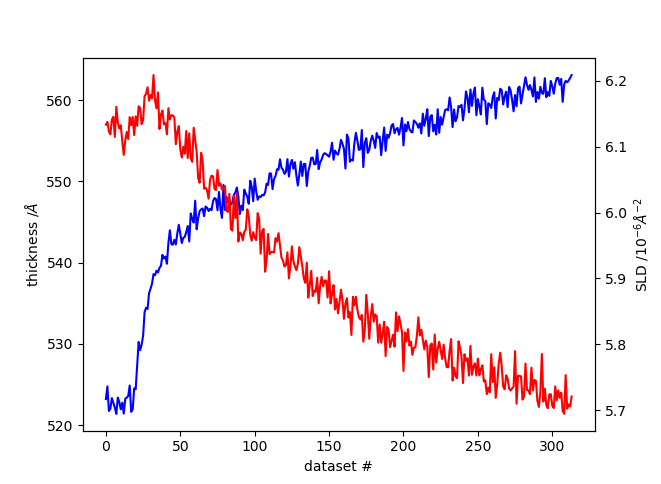

In [4]:
# now process the output

thickness = []
sld = []
for objective in obj_out:
    model = objective.model
    thickness.append(model.structure[1].thick.value)
    sld.append(model.structure[1].sld.real.value)

fig, ax1 = plt.subplots()
ax1.set_xlabel('dataset #')
ax1.set_ylabel('thickness /$\AA$')
ax1.plot(thickness, 'b')
ax2 = ax1.twinx()
ax2.plot(sld, 'r')
ax2.set_ylabel('SLD /$10^{-6}\AA^{-2}$');